In [1]:
# Assumptions
# 1. The process is defined in [0,1].
# 2. The process accepts as input a float number.
import numpy as np
import scipy
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

W = np.load('ssrw-1e8.npy')
n = len(W)
n

100000000

In [2]:
def process(x: float) -> float:
    return 2*x

def ssrw_process(x:float) -> float:
    x = x + 1e-8 # fix zero devision
    return W[int(x*n)]*(x*n)**(-1/2)

def weierstrass(x,Nvar = 100):
    we=0
    for n in range(0,Nvar):
        we=we+np.cos(3**n*np.pi*x)/2**n
    return we

process = ssrw_process
# We use the weierstrass function as a test case.
# It is continuous, not differentiable, and does
# not have other properties of BM such as normality
# and memorylessness.

/opt/homebrew/lib/python3.10/site-packages/numpy/lib/function_base.py:2414: ComplexWarning: Casting complex values to real discards the imaginary part
  res = asanyarray(outputs, dtype=otypes[0])


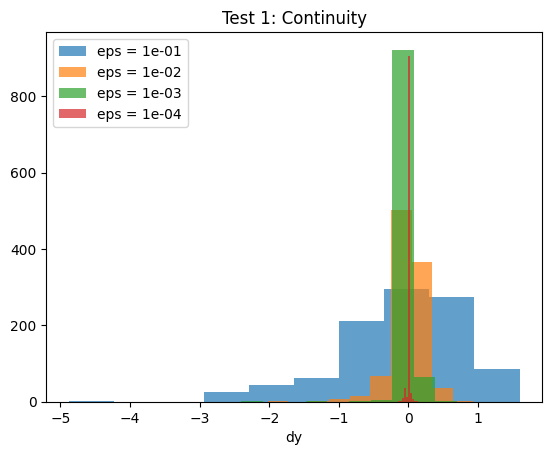

In [3]:
# Test 1: Continuity
# Pick 10 random points. For each point, pick a random direction and
# move a small distance in that direction.

n = 1000
for eps in [1e-1, 1e-2, 1e-3, 1e-4] :
    x = np.random.rand(n)
    dx = eps
    x1 = x - dx/2
    x2 = x + dx/2
    y1 = np.vectorize(process)(x1)
    y2 = np.vectorize(process)(x2)
    dy = y2 - y1
    plt.hist(dy, alpha = 0.7,
    label = f'eps = {eps:.0e}') # should be very small
plt.title('Test 1: Continuity')
plt.xlabel('dy')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


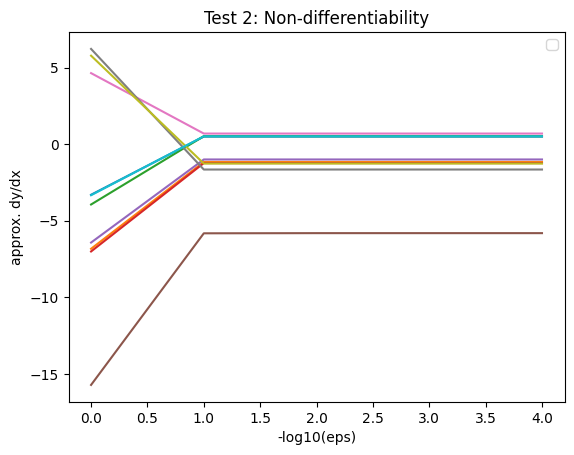

In [4]:
# Test 2: Non-differentiability

n = 10
eps = np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
x = np.random.rand(n)
dx = eps
x1 = np.tile(x, (5,1)) - np.tile(dx/2, (n,1)).T
x2 = np.tile(x, (5,1)) + np.tile(dx/2, (n,1)).T
y1 = np.vectorize(process)(x1)
y2 = np.vectorize(process)(x2)
dy = y2 - y1
plt.plot(dy / np.tile(dx, (n,1)).T,
) # should not converge
plt.title('Test 2: Non-differentiability')
plt.xlabel('-log10(eps)')
plt.ylabel('approx. dy/dx')
plt.legend()

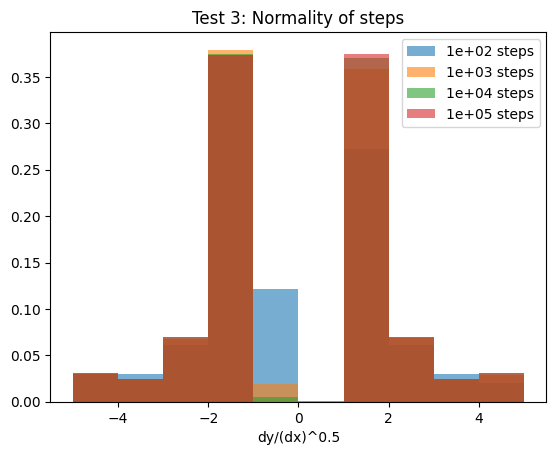

Text(0.5, 1.0, 'p-value for normal test')

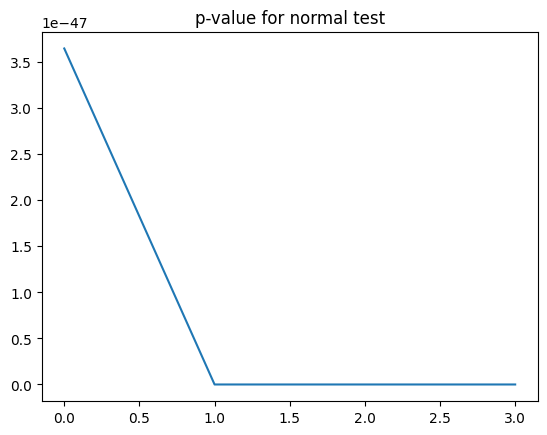

In [5]:
# Test 3: Normality of steps
# We split the interval [0,1] into n intervals. We then test 
# the normality of the steps.
# To pass the test, the steps should be normally distributed,
# with mean 0 and variance 1/n.
# Graphically, the shape of the histogram should stabalize to 
# a standard bell curve.

ps = []
for n in [1e2,1e3,1e4, 1e5]:
    x = np.linspace(0,1,int(n))
    y = np.vectorize(process)(x)
    diff = y[1:] - y[:-1]
    res = diff*(n**0.5)
    np.clip(res, -5, 5, out=res)
    *_, p = scipy.stats.normaltest(diff)
    ps.append(p)
    plt.hist(res, alpha = 0.6, 
        density = True,
        label = f'{n:.0e} steps')

plt.legend()
plt.title('Test 3: Normality of steps')
plt.xlabel('dy/(dx)^0.5')

plt.show()
plt.plot(ps)
plt.title('p-value for normal test')

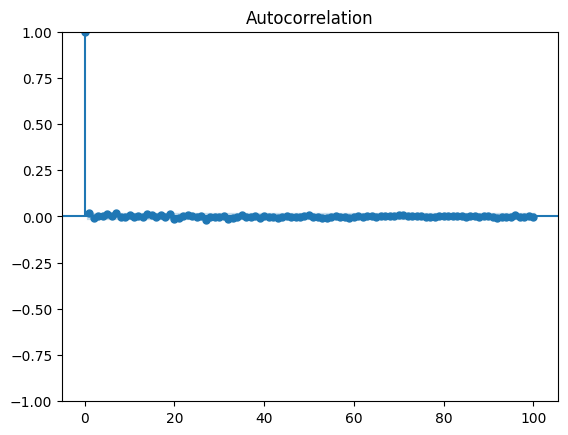

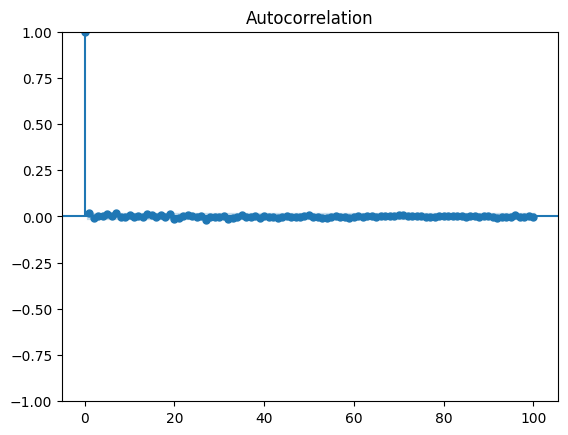

In [6]:
# Test 4: Memorylessness
# We split the interval [0,1] into n intervals. We then test
# the memorylessness of the discrete process (x1,x2,x3,...,xn)
# by testing the independence of (x1,x2) and (x2,x3).
# To pass the test, the first-order difference should be white noise.

plot_acf(
    np.diff(
    np.vectorize(process)(np.linspace(0,1,10000))
    ), lags = 100)


# Test 5: Scale invariance
# We pick a subinterval and stretch it to the whole interval.
# All test results above should be stable and make no significant change.